# Comparison of Classification Models
Michael Murrietta

3/17/2018

## Introduction
Classification is a fundamental task of many machine learning and statistical algorithms. An effort is given here to compare three different models on the task of classifying email messages as spam or ham using a single dataset. Since a subset of all available models is used for the task emphasis is made on the method of how to compare such models. Naive Bayes, Classification Trees from the CART algorithm, and random forests will be compared.

## Abstract
A dataset known as the SpamAssassin corpus was processed and modeled using the bag of words (BOW) framework and also by extracting various properties of the messages into features of a tabular dataset. Classification of spam or not-spam was the main objective and the Naive Bayes, CART, and random forest methods were compared on the basis of various metrics. The final results show that random forest to be the best overall in this situation but the Naive Bayes method used on the BOW framework was also a good choice.

#### Problem Statement:
Problem from 10.8 

Compare Naive Bayes, CART, and one other algorithm.

A comparison means at least a 5 fold CV tuned model for each.

+ Which has the best precision
+ Which has the best recall
+ Which has the best accuracy
+ Which has the best F1

Based on those questions which model performs 'best' aka which would you implement if given the choice of 1 and only 1 
(no secret option D of ensemble them all).

## Methods
The dataset was processed as documented in chapter 3 of Nolan and Lang's text (Nolan & Lang, 2015). Naive Bayes was implemented in two different ways, the first utilized the Bag of Words model of the dataset by computing the log odds of a message being spam given that a word is included in the message for every word in the training set; this method was presented by Nolan and Lang and provided a thorough look at how the algorithm works and is implemented computationally. The second way Naive Bayes was used was on the derived dataset, this method utilized the `naivebayes` package available on CRAN. The derived dataset did not include the message contents to the extent that the BOW method did but it utilized other information from the header, subject line, and attachments list. The `randomForest` and `rpart` packages were used to use the implement the random forest and classification tree (CART) methods for classifying spam messages in the derived dataset. The derived dataset required some minor preparation before it could be used in the random forest and CART models: CART required logical data to be converted to factors (the R data type), random forest required all numeric data. The metrics used for comparison are as follows:

+ Precision
+ Recall (True Positive Rate)
+ Accuracy
+ F1 score
+ False Positive Rate

The random forest model used only 100 trees and all other parameters were package defaults. The classification tree model used only the package defaults. All models except for the Naive Bayes BOW model used all variables of the derived dataset to predict the outcome. Cross validation was performed for each model using 10 folds.

Admittedly the exploration of parameters is non-existent in this exercise and the focus remained on the method of comparing multiple models. An exploration of various parameters for each model could take place similarly but may be extraneous. Another approach is to make a baseline assessment, choose the best model (like in this exercise), and then explore the parameter space for the best results possible using the chosen model.

The functions that follow are due to Nolan and Lang from chapter 3 of their text (Nolan & Lang, 2015) and are used to read in and process the messages from a sub directory named `data`.

In [1]:
#read in functions and stopwords for naive Bayes
library(tm)
stopWords = stopwords()
cleanSW = tolower(gsub("[[:punct:]0-9[:blank:]]+", " ", stopWords))
SWords = unlist(strsplit(cleanSW, "[[:blank:]]+"))
SWords = SWords[ nchar(SWords) > 1 ]
stopWords = unique(SWords)

splitMessage = function(msg) {
  splitPoint = match("", msg)
  header = msg[1:(splitPoint-1)]
  body = msg[ -(1:splitPoint) ]
  return(list(header = header, body = body))
}

getBoundary = function(header) {
  boundaryIdx = grep("boundary=", header)
  boundary = gsub('"', "", header[boundaryIdx])
  gsub(".*boundary= *([^;]*);?.*", "\\1", boundary)
}

dropAttach = function(body, boundary){
  
  bString = paste("--", boundary, sep = "")
  bStringLocs = which(bString == body)
  
  if (length(bStringLocs) <= 1) return(body)
  
  eString = paste("--", boundary, "--", sep = "")
  eStringLoc = which(eString == body)
  if (length(eStringLoc) == 0) 
    return(body[ (bStringLocs[1] + 1) : (bStringLocs[2] - 1)])
  
  n = length(body)
  if (eStringLoc < n) 
     return( body[ c( (bStringLocs[1] + 1) : (bStringLocs[2] - 1), 
                    ( (eStringLoc + 1) : n )) ] )
  
  return( body[ (bStringLocs[1] + 1) : (bStringLocs[2] - 1) ])
}
    
cleanText =
function(msg)   {
  tolower(gsub("[[:punct:]0-9[:space:][:blank:]]+", " ", msg))
}

findMsgWords = 
function(msg, stopWords) {
 if(is.null(msg))
  return(character())

 words = unique(unlist(strsplit(cleanText(msg), "[[:blank:]\t]+")))
 
 # drop empty and 1 letter words
 words = words[ nchar(words) > 1]
 words = words[ !( words %in% stopWords) ]
 invisible(words)
}

processAllWords = function(dirName, stopWords)
{
       # read all files in the directory
  fileNames = list.files(dirName, full.names = TRUE)
       # drop files that are not email, i.e., cmds
  notEmail = grep("cmds$", fileNames)
  if ( length(notEmail) > 0) fileNames = fileNames[ - notEmail ]

  messages = lapply(fileNames, readLines, encoding = "latin1")
  
       # split header and body
  emailSplit = lapply(messages, splitMessage)
       # put body and header in own lists
  bodyList = lapply(emailSplit, function(msg) msg$body)
  headerList = lapply(emailSplit, function(msg) msg$header)
  rm(emailSplit)
  
       # determine which messages have attachments
  hasAttach = sapply(headerList, function(header) {
    CTloc = grep("Content-Type", header)
    if (length(CTloc) == 0) return(0)
    multi = grep("multi", tolower(header[CTloc])) 
    if (length(multi) == 0) return(0)
    multi
  })
  
  hasAttach = which(hasAttach > 0)
  
       # find boundary strings for messages with attachments
  boundaries = sapply(headerList[hasAttach], getBoundary)
  
       # drop attachments from message body
  bodyList[hasAttach] = mapply(dropAttach, bodyList[hasAttach], 
                               boundaries, SIMPLIFY = FALSE)
  
       # extract words from body
  msgWordsList = lapply(bodyList, findMsgWords, stopWords)
  
  invisible(msgWordsList)
}

Loading required package: NLP


In [2]:
#some other constants to allow us to use the above functions when processing messages
#for naive Bayes
spamPath = "./data"
dirNames = list.files(path = paste(spamPath, "messages",
                      sep = .Platform$file.sep))
fullDirNames = paste(spamPath, "messages", dirNames, 
                     sep = .Platform$file.sep)

In [3]:
#now read in and process the raw messages using the above functions
msgWordsList = lapply(fullDirNames, processAllWords, 
                      stopWords = stopWords) 

#get number of messages in each directory
numMsgs = sapply(msgWordsList, length)
print(numMsgs)

Warning message in FUN(X[[i]], ...):
"incomplete final line found on './data/messages/hard_ham/00228.0eaef7857bbbf3ebf5edbbdae2b30493'"Warning message in FUN(X[[i]], ...):
"incomplete final line found on './data/messages/hard_ham/0231.7c6cc716ce3f3bfad7130dd3c8d7b072'"Warning message in FUN(X[[i]], ...):
"incomplete final line found on './data/messages/hard_ham/0250.7c6cc716ce3f3bfad7130dd3c8d7b072'"Warning message in FUN(X[[i]], ...):
"incomplete final line found on './data/messages/spam/00136.faa39d8e816c70f23b4bb8758d8a74f0'"Warning message in FUN(X[[i]], ...):
"incomplete final line found on './data/messages/spam/0143.260a940290dcb61f9327b224a368d4af'"

[1] 5051 1400  500 1000 1397


At this point we have `msgWordsList` which is a list of 5 sub lists corresponding to the directories from which they came. The directories are: `easy_ham`, `easy_ham_2`, `hard_ham`, `spam`, and `spam_2`. Each sub list is a list of processed messages from the respective directory.

In [4]:
#create logical labels for each message based on which folder they are in:
#the first 3 are ham the last 2 are spam
isSpam = rep(c(FALSE, FALSE, FALSE, TRUE, TRUE), numMsgs)

#flatten into a single list of msgs
msgWordsList = unlist(msgWordsList, recursive = FALSE)

The following functions are again from the text (Nolan & Lang, 2015) and are used to train a model given some training messages (`computeFreqs`) and then compute the log likelihood ratio for a given message `computeMsgLLR`.

In [5]:
computeFreqs =
function(wordsList, spam, bow = unique(unlist(wordsList)))
{
   # create a matrix for spam, ham, and log odds
  wordTable = matrix(0.5, nrow = 4, ncol = length(bow), 
                     dimnames = list(c("spam", "ham", 
                                        "presentLogOdds", 
                                        "absentLogOdds"),  bow))

   # For each spam message, add 1 to counts for words in message
  counts.spam = table(unlist(lapply(wordsList[spam], unique)))
  wordTable["spam", names(counts.spam)] = counts.spam + .5

   # Similarly for ham messages
  counts.ham = table(unlist(lapply(wordsList[!spam], unique)))  
  wordTable["ham", names(counts.ham)] = counts.ham + .5  


   # Find the total number of spam and ham
  numSpam = sum(spam)
  numHam = length(spam) - numSpam

   # Prob(word|spam) and Prob(word | ham)
  wordTable["spam", ] = wordTable["spam", ]/(numSpam + .5)
  wordTable["ham", ] = wordTable["ham", ]/(numHam + .5)
  
   # log odds
  wordTable["presentLogOdds", ] = 
     log(wordTable["spam",]) - log(wordTable["ham", ])
  wordTable["absentLogOdds", ] = 
     log((1 - wordTable["spam", ])) - log((1 -wordTable["ham", ]))

  invisible(wordTable)
}

In [6]:
#compute LLR of a processed message
computeMsgLLR = function(words, freqTable) 
{
       # Discards words not in training data.
  words = words[!is.na(match(words, colnames(freqTable)))]

       # Find which words are present
  present = colnames(freqTable) %in% words

  sum(freqTable["presentLogOdds", present]) +
    sum(freqTable["absentLogOdds", !present])
}

These functions are adapted from the `typeIErrorRate` function given by Nolan and Lang, these calculate all rates from the 2 x 2 confusion matrix associated with threshold `tau`, the log likelihood ratios `llrVals`, and the labels of spam or not-spam `spam`.

### Testing Naive Bayes
Here we test the naive Bayes method as implemented in the Nolan and Lang's text (Nolan & Lang, 2015) using 10 fold cross validation. Most of the code below is taken from the text but was modified to easily calculate the metrics of interest as well as to produce the ROC plot.

The work in chapter 3 of the text suggests that -35 is a choice for threshold that will produce a false positive rate of 0.01 and a false negative rate of about 0.06. The way this was arrived at was by pooling together the out-of-fold false positive/negative rates and then selecting the threshold that accounted for the best false negative rate after subsetting for thresholds that produced a false positive rate of 0.01. This was in effort to select the best threshold for the model independent of the training set used.

In this case the threshold of -35 is retained where log likelihood ratios less than or equal to -35 are considered not spam and those with log likelihood ratios greater than -35 are considered to be spam.

In [7]:
#calculate confusion matrix proportions and some other measures of error
#adapted from previous definition but now for a generic vector of predictions and true labels (no threshold needed)
falsePosRate = 
function(yhat, y)
{
  sum(yhat & !y)/sum(!y) #sum all false positives divide by sum of all actual positives
}
falseNegRate = 
function(yhat, y)
{
  sum(!yhat & y)/sum(y) #sum all false positives divide by sum of all actual positives
}
truePosRate = 
function(yhat, y)
{
  sum(yhat & y)/sum(y)
}
trueNegRate = 
function(yhat, y)
{
  sum(!yhat & !y)/sum(!y) #sum all non-spam that were actually negative, divide by all negatives
}
#precision is number of true positives divided by number of all predicted positives
precision = function(yhat, y)
{
  sum(yhat & y)/sum(yhat)
}
#recall is number of true positives divided by number of all actual positives
#which is just the true positive rate for which we already have a function to use

#f1 score is the harmonic mean of precision and recall
f1score = function(yhat, y)
{
  prec = precision(yhat, y)
  rec = truePosRate(yhat, y)
  (2*prec*rec)/(prec + rec)
}

accuracy = function(yhat, y)
{
  (sum(yhat & y) + sum(!yhat & !y))/length(y)
}

In [8]:
#now collect FPR and TPR for each fold using the suggested threshold from the previous analysis
k = 10 #set k
numTrain = length(msgWordsList) #get number of training observations
partK = sample(numTrain) #randomly sample digits between 1 and numTrain
tot = k * floor(numTrain/k) #set the total number of observations we'll use in all k folds, ensures even amounts
partK = matrix(partK[1:tot], ncol = k) #matrix using the the first tot items in the vector version of partK

testFoldOdds = NULL #a blank vector: we'll append the Odds vectors produced for each test fold
for (i in 1:k) {
  foldIdx = partK[ , i] #use column i in partK to test, use the rest for training
  trainTabFold = computeFreqs(msgWordsList[-foldIdx], isSpam[-foldIdx])
  testFoldOdds = c(testFoldOdds, 
               sapply(msgWordsList[ foldIdx ], computeMsgLLR, trainTabFold))
}

testFoldSpam = NULL #blank vector that gets the labels for spam or not spam of each test fold
for (i in 1:k) {
  foldIdx = partK[ , i]
  testFoldSpam = c(testFoldSpam, isSpam[foldIdx])
}

In [9]:
#apply our threshold to the odds
testFoldPred = testFoldOdds > -35
#expand the predictions and actual labels into matrices, one column for each set of out-of-sample folds
testFoldPred = matrix(testFoldPred, ncol=k)
testFoldSpam = matrix(testFoldSpam, ncol=k)

In [10]:
#calculate our metrics for naive Bayes
cvratesNBbow = cbind("fold" = 1:k,
              "method" = rep("naive_bayes_bow",k),
              "tpr" = unlist(lapply(1:k, function(i) truePosRate(testFoldPred[,i], testFoldSpam[,i]))), 
              "fpr" = unlist(lapply(1:k, function(i) falsePosRate(testFoldPred[,i], testFoldSpam[,i]))),
              "prec" = unlist(lapply(1:k, function(i) precision(testFoldPred[,i], testFoldSpam[,i]))),
              "f1" = unlist(lapply(1:k, function(i) f1score(testFoldPred[,i], testFoldSpam[,i]))),
              "acc" = unlist(lapply(1:k, function(i) accuracy(testFoldPred[,i], testFoldSpam[,i]))))
cvratesNBbow

fold,method,tpr,fpr,prec,f1,acc
1,naive_bayes_bow,0.94468085106383,0.0143061516452074,0.956896551724138,0.950749464668094,0.975374732334047
2,naive_bayes_bow,0.947368421052632,0.00727802037845706,0.97907949790795,0.962962962962963,0.980728051391863
3,naive_bayes_bow,0.950617283950617,0.00434153400868307,0.987179487179487,0.968553459119497,0.983940042826552
4,naive_bayes_bow,0.958715596330275,0.00837988826815642,0.972093023255814,0.965357967667437,0.983940042826552
5,naive_bayes_bow,0.959641255605381,0.00562587904360056,0.981651376146789,0.970521541950113,0.986081370449679
6,naive_bayes_bow,0.974576271186441,0.0143266475644699,0.958333333333333,0.966386554621849,0.982869379014989
7,naive_bayes_bow,0.950191570881226,0,1,0.974459724950884,0.986081370449679
8,naive_bayes_bow,0.960629921259842,0.00441176470588235,0.987854251012146,0.974051896207585,0.986081370449679
9,naive_bayes_bow,0.95397489539749,0.00719424460431655,0.978540772532189,0.966101694915254,0.982869379014989
10,naive_bayes_bow,0.954166666666667,0.0129682997118156,0.96218487394958,0.9581589958159,0.978586723768737


#### The other models
The preceding work was not just a naive Bayes classifier but a naive Bayes classifier using a bag-of-words framework. While it is not impossible to use the bag-of-words framework for the other models it will require some work to get the data into a usable format using bag-of-words. The following section will instead import the derived dataset as described in Nolan and Lang's text and proceed to use `naive_bayes`, `rpart`, and `random_forest` classifiers from their respective packages.

In [11]:
#load the data
#this is for the CART part later
load("spamAssassinDerivedDF.rda")
print(dim(emailDF))

[1] 9348   30


In [12]:
#some setup for naivebayes
library(naivebayes)

In [13]:
#some setup for rpart, this is from Nolan and Lang's code
library(rpart)

setupRpart = function(data) {
  logicalVars = which(sapply(data, is.logical))
  facVars = lapply(data[ , logicalVars], 
                   function(x) {
                      x = as.factor(x)
                      levels(x) = c("F", "T")
                      x
                   })
  cbind(facVars, data[ , - logicalVars])
}

emailDFrp = setupRpart(emailDF)

In [14]:
#some setup for random forest
#taken from Professor Slater's notebook
#tried using randomForest on emailDF and quickly realized there was something wrong
library(randomForest)
setupRnum = function(data) {
  logicalVars = which(sapply(data, is.logical))
  facVars = lapply(data[ , logicalVars], 
                   function(x) {
                      x = as.numeric(x)
                   })
  cbind(facVars, data[ , - logicalVars])
}

emailDFnum = setupRnum(emailDF)

#convert any na's to 0
emailDFnum[is.na(emailDFnum)] <- 0

Warning message:
"package 'randomForest' was built under R version 3.4.4"randomForest 4.6-12
Type rfNews() to see new features/changes/bug fixes.


In [15]:
#set the seed for reproducibility
#i'm not using caret, obviously. cv doesn't seem too unmanageable at this time
set.seed(418910)

#setup our folds, we'll use the same folds for every model we try
k = 10 #set k
numTrain = dim(emailDF)[1] #get number of training observations
partK = sample(numTrain) #randomly sample digits between 1 and numTrain
tot = k * floor(numTrain/k) #set the total number of observations we'll use in all k folds, ensures even amounts
partK = matrix(partK[1:tot], ncol = k) #matrix using the the first tot items in the vector version of partK

In [16]:
#checking if the proportion of spam in our folds is similar to the actual
lapply(1:k, function(i) sum(emailDF[partK[,i],"isSpam"])/(dim(partK)[1]))

[[1]]
[1] 0.2773019

[[2]]
[1] 0.2826552

[[3]]
[1] 0.2473233

[[4]]
[1] 0.2655246

[[5]]
[1] 0.2591006

[[6]]
[1] 0.2430407

[[7]]
[1] 0.2462527

[[8]]
[1] 0.245182

[[9]]
[1] 0.2430407

[[10]]
[1] 0.2537473

In [17]:
#running cv for all models
testFoldPredNB = NULL
testFoldPredRP = NULL
testFoldPredRF = NULL
testFoldSpam = NULL
for (i in 1:k) {
  foldIdx = partK[ , i] #isolate indices for testing
  nb <- naive_bayes(isSpam ~ ., data=emailDF[-foldIdx,]) #train with all data except for the test fold 
  rp <- rpart(isSpam ~ ., data = emailDFrp[-foldIdx,], method = "class")
  rf <- randomForest(as.factor(isSpam) ~ ., data=emailDFnum[-foldIdx,], ntree=100)
  testFoldPredNB = c(testFoldPredNB, as.logical(predict(nb, newdata=emailDF[foldIdx,])))
  testFoldPredRP = c(testFoldPredRP, apply(predict(rp, newdata=emailDFrp[foldIdx,]),1, 
                                           function(x) which.max(x)-1) == 1)
  testFoldPredRF = c(testFoldPredRF, (predict(rf, newdata=emailDFnum[foldIdx,]) == 1))
  testFoldSpam = c(testFoldSpam, emailDF[foldIdx,'isSpam'])
}

#expand the odds and actual labels into matrices, one column for each set of out-of-sample folds
testFoldPredNB = matrix(testFoldPredNB, ncol=k)
testFoldPredRP = matrix(testFoldPredRP, ncol=k)
testFoldPredRF = matrix(testFoldPredRF, ncol=k)
testFoldSpam = matrix(testFoldSpam, ncol=k)

The error metrics were already calculated for Naive Bayes using BOW, a similar computation will be done for the cross validation just completed.

In [18]:
#now we can calculate all of our metrics for naivebayes and place it in nice matrix format
nbcvrates = cbind("fold" = 1:k,
              "method" = rep("naive_bayes",k),
              "tpr" = unlist(lapply(1:k, function(i) truePosRate(testFoldPredNB[,i], testFoldSpam[,i]))), 
              "fpr" = unlist(lapply(1:k, function(i) falsePosRate(testFoldPredNB[,i], testFoldSpam[,i]))),
              "prec" = unlist(lapply(1:k, function(i) precision(testFoldPredNB[,i], testFoldSpam[,i]))),
              "f1" = unlist(lapply(1:k, function(i) f1score(testFoldPredNB[,i], testFoldSpam[,i]))),
              "acc" = unlist(lapply(1:k, function(i) accuracy(testFoldPredNB[,i], testFoldSpam[,i]))))
rpcvrates = cbind("fold" = 1:k,
              "method" = rep("rpart",k),
              "tpr" = unlist(lapply(1:k, function(i) truePosRate(testFoldPredRP[,i], testFoldSpam[,i]))), 
              "fpr" = unlist(lapply(1:k, function(i) falsePosRate(testFoldPredRP[,i], testFoldSpam[,i]))),
              "prec" = unlist(lapply(1:k, function(i) precision(testFoldPredRP[,i], testFoldSpam[,i]))),
              "f1" = unlist(lapply(1:k, function(i) f1score(testFoldPredRP[,i], testFoldSpam[,i]))),
              "acc" = unlist(lapply(1:k, function(i) accuracy(testFoldPredRP[,i], testFoldSpam[,i]))))
rfcvrates = cbind("fold" = 1:k,
              "method" = rep("randomForest",k),
              "tpr" = unlist(lapply(1:k, function(i) truePosRate(testFoldPredRF[,i], testFoldSpam[,i]))), 
              "fpr" = unlist(lapply(1:k, function(i) falsePosRate(testFoldPredRF[,i], testFoldSpam[,i]))),
              "prec" = unlist(lapply(1:k, function(i) precision(testFoldPredRF[,i], testFoldSpam[,i]))),
              "f1" = unlist(lapply(1:k, function(i) f1score(testFoldPredRF[,i], testFoldSpam[,i]))),
              "acc" = unlist(lapply(1:k, function(i) accuracy(testFoldPredRF[,i], testFoldSpam[,i]))))
cvrates = rbind(cvratesNBbow, nbcvrates, rpcvrates, rfcvrates)

In [19]:
#this will put "method" as the first column
cvrates = as.matrix(merge(cvrates, cbind("method"=unique(cvrates[,2]),"num_method"=c(1,2,3,4))))

Below the average value for each metric is displayed for each method as well as a receiver operating characteristic plot. The plot shows where each out-of-fold test placed on the FPR and TPR axes. For each metric the ideal is a value of 1 except for the false positive rate of which the ideal value is 0. The average metric values show that `naive_bayes_bow` and `randomForest` are both attaining the best values while `naive_bayes` and `rpart` do not once attain a best average metric value.

In [20]:
avgCVrates = t(matrix(unlist(lapply(unique(cvrates[,1]), function(m) 
    lapply(3:7, function(i) 
        mean(as.numeric(cvrates[cvrates[,1]==m,i]))))),ncol=4))
        
avgCVrates = cbind(unique(cvrates[,1]),avgCVrates)
colnames(avgCVrates) = c("method", "tpr", "fpr", "prec", "f1", "acc")
avgCVrates

method,tpr,fpr,prec,f1,acc
naive_bayes,0.730814590991379,0.054079181908274,0.822868780425136,0.773654756337675,0.8906852248394
naive_bayes_bow,0.95545627333944,0.00788324299305889,0.976381316704143,0.965730426287958,0.982655246252677
randomForest,0.942260302032631,0.00777128330245932,0.976590718237285,0.959069263893225,0.979443254817987
rpart,0.816029465100105,0.0526621655812766,0.842264843623524,0.82862084646381,0.913704496788009


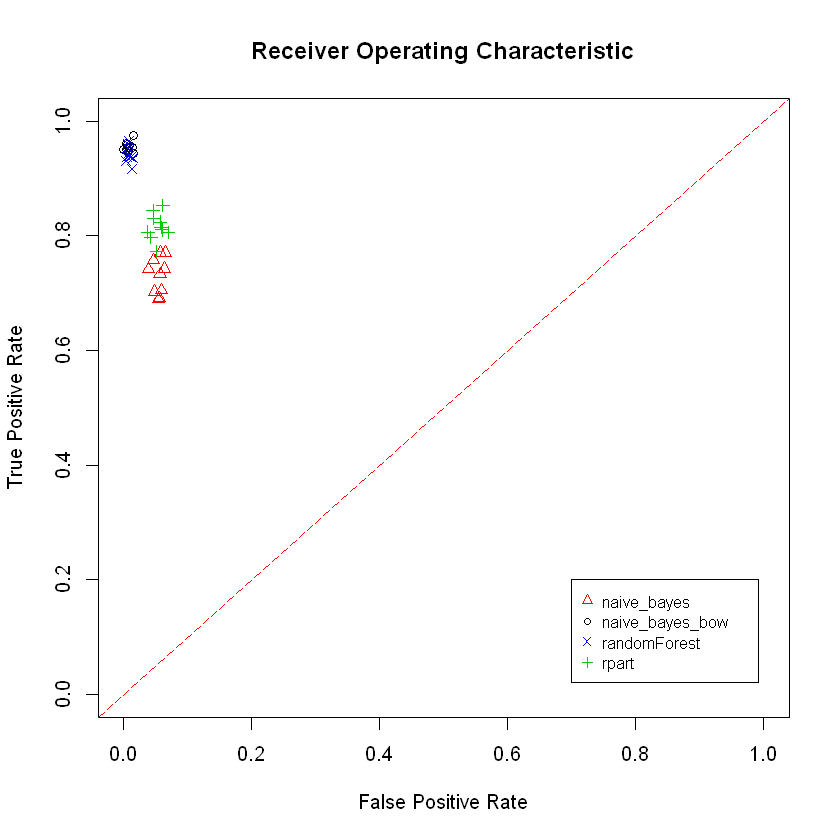

In [21]:
plot(cvrates[,4], cvrates[,3], ylim=c(0,1), xlim=c(0,1), pch=as.integer(cvrates[,8]), col=cvrates[,8],
     xlab="False Positive Rate", ylab="True Positive Rate", main="Receiver Operating Characteristic")
abline(0, 1, lty=5, col="red")
legend(0.7, 0.2, legend=unique(cvrates[,1]),
       col=as.integer(unique(cvrates[,8])), pch=as.integer(unique(cvrates[,8])), cex=0.8)

## Results

The best metric for comparing classification models in this scenario is the f1 score since it incorporates both precision and the true positive rate (recall). For the email client user the precision part informs us of how much of my wanted mail is being incorrectly classified by the model (1 - precision), the recall part tells us how much of the all possible spam did the model catch. Each of these is certainly important so to be able to effectively summarize them in a single score makes the f1 score a good choice. Using the f1 score as the ultimate metric shows the `naive_bayes_bow` method to be the best with an average out-of-fold f1 score of `0.965`. It is also clear in the ROC plot that the `naive_bayes_bow` method is the best but with the 100 tree `randomForest` model very close.

## Conclusion

The f1 score seemed to be the best metric for this scenario as it summarizes two important aspects of classification model performance. While there are some improvements to be made on the bag of words framework used with Naive Bayes the random forest model could still end up performing better. Indeed, it would be a simpler task to try various parameters on the random forest model than it would to make adjustments to the bag of words.

## References
[1] Nolan, Deborah and Lang, Temple. Data Science in R: A Case Studies Approach, Chapter 3: Using Statistics to Identify Spam. 2015 Taylor & Francis Group, LLC.